In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys 
import os
import skimage.io
import caffe
from scipy.misc import imread,toimage
caffe.set_mode_gpu()

import visualisation
import excitation_backprop
import debug
import beoid

%load_ext autoreload
%autoreload 2

In [79]:
import beoid_spatial_config
import beoid_temporal_config

spatial_net_config = beoid_spatial_config
temporal_net_config = beoid_temporal_config
spatial_net_name = "spatial_beoid"
temporal_net_name = "temporal_beoid"

spatial_net = caffe.Net(spatial_net_config.net_prototxt_path,
                spatial_net_config.net_caffemodel_path,
                caffe.TEST)
temporal_net = caffe.Net(temporal_net_config.net_prototxt_path,
                temporal_net_config.net_caffemodel_path,
                caffe.TEST)


In [3]:
extensions = ['pdf', 'png']

In [4]:
debug.filter_shapes(temporal_net)

{'conv1_1': (64, 20, 3, 3),
 'conv1_2': (64, 64, 3, 3),
 'conv2_1': (128, 64, 3, 3),
 'conv2_2': (128, 128, 3, 3),
 'conv3_1': (256, 128, 3, 3),
 'conv3_2': (256, 256, 3, 3),
 'conv3_3': (256, 256, 3, 3),
 'conv4_1': (512, 256, 3, 3),
 'conv4_2': (512, 512, 3, 3),
 'conv4_3': (512, 512, 3, 3),
 'conv5_1': (512, 512, 3, 3),
 'conv5_2': (512, 512, 3, 3),
 'conv5_3': (512, 512, 3, 3),
 'fc6': (4096, 25088),
 'fc7': (4096, 4096),
 'fc8': (34, 4096)}

In [5]:
debug.filter_shapes(spatial_net)

{'conv1_1': (64, 3, 3, 3),
 'conv1_2': (64, 64, 3, 3),
 'conv2_1': (128, 64, 3, 3),
 'conv2_2': (128, 128, 3, 3),
 'conv3_1': (256, 128, 3, 3),
 'conv3_2': (256, 256, 3, 3),
 'conv3_3': (256, 256, 3, 3),
 'conv4_1': (512, 256, 3, 3),
 'conv4_2': (512, 512, 3, 3),
 'conv4_3': (512, 512, 3, 3),
 'conv5_1': (512, 512, 3, 3),
 'conv5_2': (512, 512, 3, 3),
 'conv5_3': (512, 512, 3, 3),
 'fc6': (4096, 25088),
 'fc7': (4096, 4096),
 'fc8': (34, 4096)}

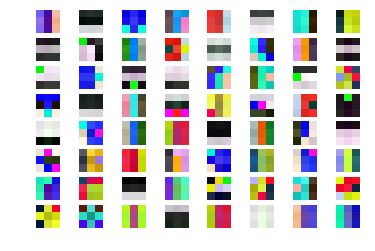

In [81]:
layer = 'conv1_1'
spatial_filters = visualisation.show_filters(spatial_net, layer)
for ext in extensions:
    spatial_filters.savefig('{}_{}_filters.{}'.format(spatial_net_name, layer, ext))
spatial_filters

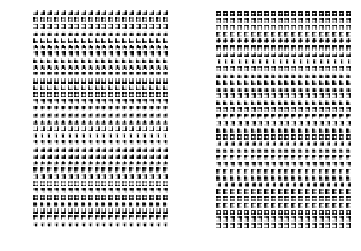

In [75]:
temporal_conv1_1_filter_vis = visualisation.show_grayscale_filters(temporal_net, 'conv1_1', 
                                                                   scaling_method=visualisation.SCALING_METHODS.KERNEL_SLICE)
plt.show()

half_height = int(len(temporal_conv1_1_filter_vis)/2)
                  
plt.clf()
fig, axes = plt.subplots(1, 2)
axes[0].imshow(temporal_conv1_1_filter_vis[:half_height], cmap='gray')
axes[0].axis('off')
axes[1].imshow(temporal_conv1_1_filter_vis[half_height:], cmap='gray')
axes[1].axis('off')
plt.savefig('temporal_conv1_1_beoid_figure.png')
plt.savefig('temporal_conv1_1_beoid_figure.pdf')
plt.show()
plt.clf()

In [67]:
third_last_filter = temporal_net.params['conv1_1'][0].data[-3]
last_filter = temporal_net.params['conv1_1'][0].data[-1]
print(third_last_filter.shape)
print(last_filter.shape)
print(third_last_filter[0])
print(last_filter[0])

(20, 3, 3)
(20, 3, 3)
[[-0.11021307 -0.11919151 -0.11723115]
 [-0.08962592 -0.02022405 -0.12066086]
 [-0.12711222 -0.10113279 -0.13819917]]
[[ 0.02133455 -0.06341673 -0.34088576]
 [ 0.37232706  0.39033887 -0.26115718]
 [ 0.07138209  0.06664818 -0.29118317]]


In [69]:
block_configurations = [(block, block_id) for block, block_limit in [(1, 2), (2, 2), (3, 3), (4, 3), (5, 3)]
                                          for block_id in range(1, block_limit + 1)]
conv_layers = ["conv{}_{}".format(block, block_id) for block, block_id in block_configurations]
conv_layers

['conv1_1',
 'conv1_2',
 'conv2_1',
 'conv2_2',
 'conv3_1',
 'conv3_2',
 'conv3_3',
 'conv4_1',
 'conv4_2',
 'conv4_3',
 'conv5_1',
 'conv5_2',
 'conv5_3']

In [70]:
dataset_name = "beoid"
for net_name, net in [('spatial', spatial_net), ('temporal', temporal_net)]:
    for conv_layer in conv_layers:
        filters = toimage(visualisation.show_grayscale_filters(net, conv_layer))
        filters.save('{}_{}_{}_filters.png'.format(net_name, dataset_name, conv_layer))

In [72]:
for name, net in [("spatial", spatial_net), ("temporal", temporal_net)]:
    for fc_layer in ['fc6', 'fc7']:
        toimage(visualisation.show_grayscale_filters(net, fc_layer)).save(
            '{}_{}_{}.png'.format(name, dataset_name, fc_layer))